# Анализ данных и построение регрессионных моделей


В данном проекте выполняются следующие задачи:
1. Построение ридж-регрессии, проверка мультиколлинеарности и сравнительный анализ с линейной регрессией.
2. Построение квантильной регрессии, графическая визуализация, сравнение с линейной регрессией.
3. Построение линейной, квадратичной и кубической моделей регрессии для сравнения.


In [2]:

# Импорты
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
blood_data = pd.read_excel("data/blood.xlsx")  # Укажите путь к файлу
kuiper_data = pd.read_excel("data/Kuiper.xls")  # Укажите путь к файлу
column_names = ['Brand', 'CO', 'Tar', 'Nicotine', 'Weight']
cigarettes_data = pd.read_csv(
'data/cigarettes.dat.txt',
    delim_whitespace=True,  # Использовать пробелы как разделители
    header=None,            # Файл не содержит заголовков
    names=column_names      # Назначение имен столбцам
)  

blood_data


C:\Users\stepa\AppData\Local\Temp\ipykernel_4812\149641272.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  cigarettes_data = pd.read_csv(


,X1,X2,X3
0,132,52,173
1,143,59,184
2,153,67,194
3,162,73,211
4,154,64,196
5,168,74,220
6,137,54,188
7,149,61,188
8,159,65,207
9,128,46,167


## 1. Ридж-регрессия для датасета blood.xlsx

c:\GitHub\Data-Analytics\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
c:\GitHub\Data-Analytics\.venv\Lib\site-packages\sklearn\utils\deprecation.py:102: FutureWarning: Attribute `cv_values_` is deprecated in version 1.5 and will be removed in 1.7. Use `cv_results_` instead.
  warnings.warn(msg, category=FutureWarning)


Лучший параметр альфа для ридж-регрессии: 0.8697490026177834
Коэффициенты ридж-регрессии: [6.6499966  5.85597916]
Свободный член: 150.0909090909091


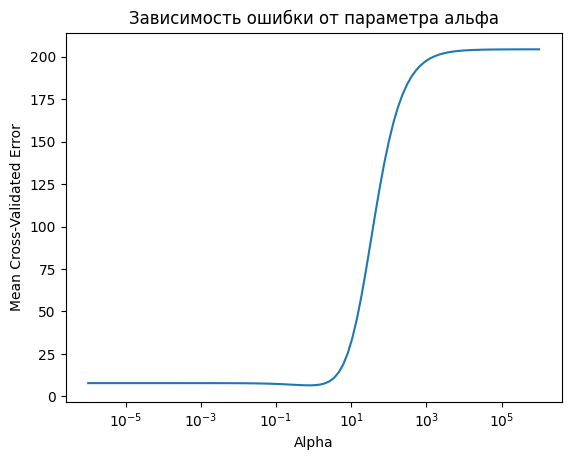

In [3]:

# Данные
X = blood_data[['X2', 'X3']]
y = blood_data['X1']

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ридж-регрессия с кросс-валидацией
from sklearn.linear_model import RidgeCV
alphas = np.logspace(-6, 6, 100)
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True).fit(X_scaled, y)
ridge_best_alpha = ridge_cv.alpha_

print(f"Лучший параметр альфа для ридж-регрессии: {ridge_best_alpha}")

# Построение модели
ridge = Ridge(alpha=ridge_best_alpha)
ridge.fit(X_scaled, y)

# Вывод коэффициентов и уравнения
coefficients = ridge.coef_
intercept = ridge.intercept_
print(f"Коэффициенты ридж-регрессии: {coefficients}")
print(f"Свободный член: {intercept}")

# Визуализация зависимости ошибки от альфа
cv_errors = np.mean(ridge_cv.cv_values_, axis=0)
plt.plot(alphas, cv_errors)
plt.xscale('log')
plt.xlabel("Alpha")
plt.ylabel("Mean Cross-Validated Error")
plt.title("Зависимость ошибки от параметра альфа")
plt.show()


### Проверка мультиколлинеарности

In [4]:

# Проверка мультиколлинеарности с использованием VIF (Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_const = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i+1) for i in range(len(X.columns))]

print("VIF для независимых переменных:")
print(vif_data)


VIF для независимых переменных:
  Feature       VIF
0      X2  9.525022
1      X3  9.525022


### Проверка значимости


In [5]:
#Проверка значимости модели с использованием F-теста
X_const = sm.add_constant(X)
model = sm.OLS(y, X_const).fit()
print(model.summary())

# Проверка гипотезы о значимости модели
F_statistic = model.fvalue
F_p_value = model.f_pvalue
print(f"F-статистика: {F_statistic}")
print(f"p-value: {F_p_value}")



                            OLS Regression Results                            
Dep. Variable:                     X1   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     168.8
Date:                Mon, 18 Nov 2024   Prob (F-statistic):           2.87e-07
Time:                        10:14:22   Log-Likelihood:                -23.106
No. Observations:                  11   AIC:                             52.21
Df Residuals:                       8   BIC:                             53.40
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.9941     11.944      2.595      0.0

c:\GitHub\Data-Analytics\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=11 observations were given.
  return hypotest_fun_in(*args, **kwds)


### Сравнение моделей

In [6]:
#Сравнение моделей ридж-регрессии и обычной линейной регрессии по методу наименьших квадратов
# Данные
X = blood_data[['X2', 'X3']]
y = blood_data['X1']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучение моделей
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

ridge = Ridge(alpha=ridge_best_alpha)
ridge.fit(X_train, y_train)

# Предсказание
y_pred_lin_reg = lin_reg.predict(X_test)
y_pred_ridge = ridge.predict(X_test)

# Оценка качества моделей
mse_lin_reg = mean_squared_error(y_test, y_pred_lin_reg)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

r2_lin_reg = r2_score(y_test, y_pred_lin_reg)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"MSE линейной регрессии: {mse_lin_reg}")
print(f"MSE ридж-регрессии: {mse_ridge}")
print(f"R^2 линейной регрессии: {r2_lin_reg}")
print(f"R^2 ридж-регрессии: {r2_ridge}")

MSE линейной регрессии: 1.5835130027286741
MSE ридж-регрессии: 1.5528183905959638
R^2 линейной регрессии: 0.9954067788173208
R^2 ридж-регрессии: 0.9954958132252474


## 2. Квантильная регрессия для Kuiper.xls

In [7]:
kuiper_data.head()

,Price,Mileage,Make,Model,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
0,17314.103129,8221,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,1
1,17542.036083,9135,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
2,16218.847862,13196,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
3,16336.913140,16342,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,0
4,16339.170324,19832,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,1


Квантильная регрессия для tau=0.2:
                         QuantReg Regression Results                          
Dep. Variable:                  Price   Pseudo R-squared:               0.3325
Model:                       QuantReg   Bandwidth:                       3550.
Method:                 Least Squares   Sparsity:                        8913.
Date:                Mon, 18 Nov 2024   No. Observations:                  804
Time:                        10:14:22   Df Residuals:                      798
                                        Df Model:                            5
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6727.9781    521.009     12.913      0.000    5705.268    7750.688
Mileage       -0.1151      0.015     -7.540      0.000      -0.145      -0.085
Liter       3622.1879    107.149     33.805      0.000    3411.860    3832.515
Cruise       578.

c:\GitHub\Data-Analytics\.venv\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


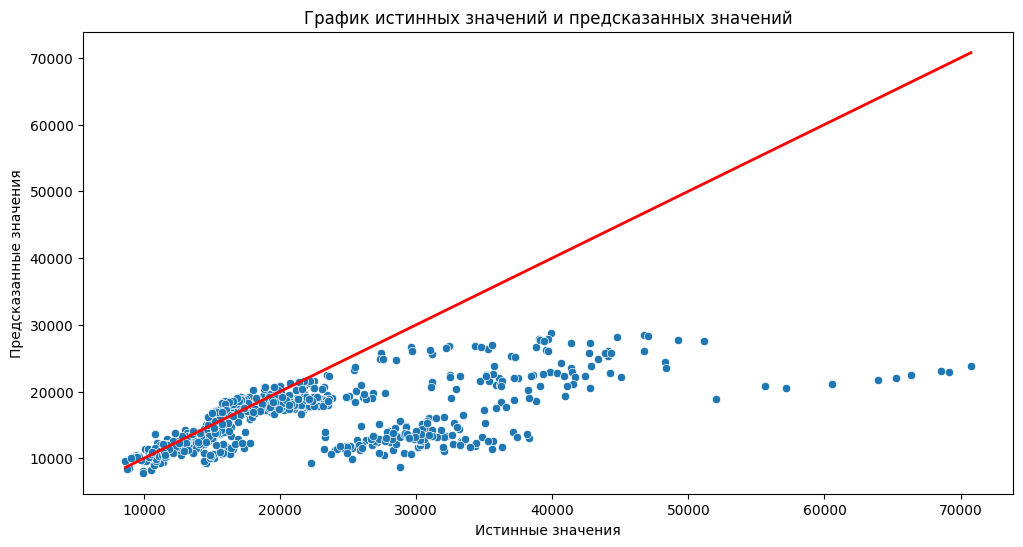

Квантильная регрессия для tau=0.5:
                         QuantReg Regression Results                          
Dep. Variable:                  Price   Pseudo R-squared:               0.2688
Model:                       QuantReg   Bandwidth:                       3265.
Method:                 Least Squares   Sparsity:                        9435.
Date:                Mon, 18 Nov 2024   No. Observations:                  804
Time:                        10:14:22   Df Residuals:                      798
                                        Df Model:                            5
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6694.0591    737.252      9.080      0.000    5246.877    8141.241
Mileage       -0.1252      0.020     -6.157      0.000      -0.165      -0.085
Liter       4419.2805    164.186     26.916      0.000    4096.992    4741.569
Cruise      1252.

c:\GitHub\Data-Analytics\.venv\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


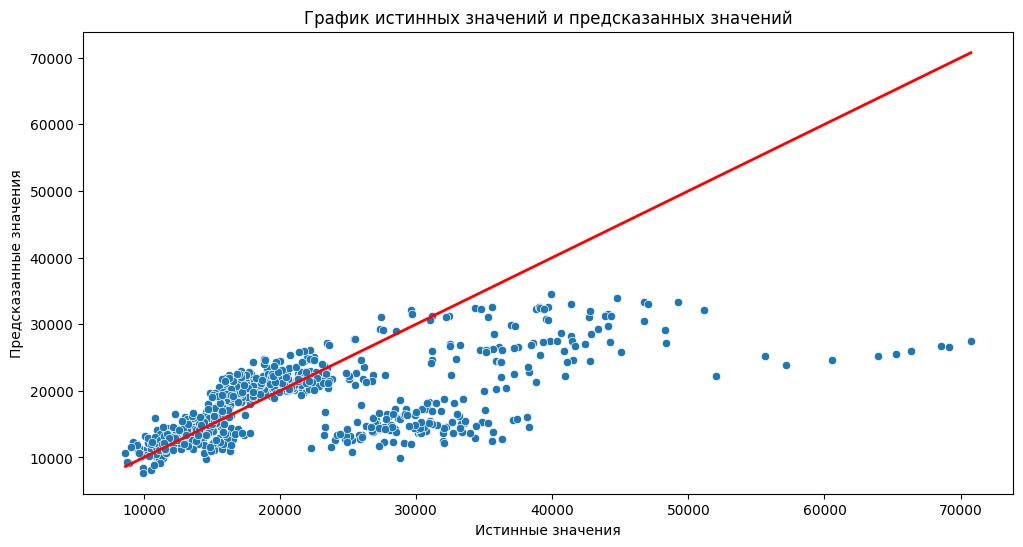

Квантильная регрессия для tau=0.8:
                         QuantReg Regression Results                          
Dep. Variable:                  Price   Pseudo R-squared:               0.3277
Model:                       QuantReg   Bandwidth:                       4428.
Method:                 Least Squares   Sparsity:                    1.730e+04
Date:                Mon, 18 Nov 2024   No. Observations:                  804
Time:                        10:14:23   Df Residuals:                      798
                                        Df Model:                            5
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.059e+04   1200.199      8.827      0.000    8238.554     1.3e+04
Mileage       -0.1534      0.032     -4.867      0.000      -0.215      -0.092
Liter       3146.5785    271.163     11.604      0.000    2614.302    3678.855
Cruise      1.385

c:\GitHub\Data-Analytics\.venv\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


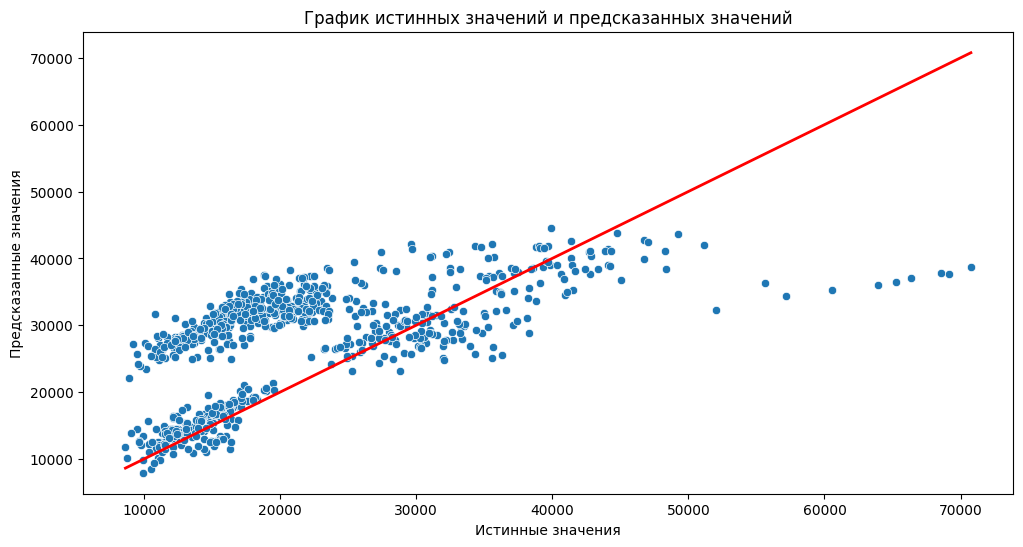

In [8]:

# Квантильная регрессия
X = kuiper_data[['Mileage', 'Liter', 'Cruise', 'Sound', 'Leather']]
y = kuiper_data['Price']
X_const = sm.add_constant(X)

taus = [0.2, 0.5, 0.8]  # Квантильные уровни
for tau in taus:
    quantile_model = QuantReg(y, X_const).fit(q=tau)
    print(f"Квантильная регрессия для tau={tau}:")
    print(quantile_model.summary())

    # Графическая визуализация
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=y, y=quantile_model.fittedvalues)
    plt.xlabel("Истинные значения")
    plt.ylabel("Предсказанные значения")

    plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', lw=2)
    plt.title("График истинных значений и предсказанных значений")
    plt.show()




### Сравнение


In [9]:
#Сравнение модели линейной регрессии и модели медианной регрессии
# Данные
X = kuiper_data[['Mileage', 'Liter', 'Cruise', 'Sound', 'Leather']]
y = kuiper_data['Price']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучение моделей
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

quantile_model = QuantReg(y_train, X_train).fit(q=0.5)

# Предсказание
y_pred_lin_reg = lin_reg.predict(X_test)
y_pred_quantile = quantile_model.predict(X_test)

# Оценка качества моделей
mse_lin_reg = mean_squared_error(y_test, y_pred_lin_reg)
mse_quantile = mean_squared_error(y_test, y_pred_quantile)

r2_lin_reg = r2_score(y_test, y_pred_lin_reg)
r2_quantile = r2_score(y_test, y_pred_quantile)

print(f"MSE линейной регрессии: {mse_lin_reg}")
print(f"MSE медианной регрессии: {mse_quantile}")
print(f"R^2 линейной регрессии: {r2_lin_reg}")
print(f"R^2 медианной регрессии: {r2_quantile}")

MSE линейной регрессии: 49006340.25223833
MSE медианной регрессии: 62226380.81661322
R^2 линейной регрессии: 0.4583066086706358
R^2 медианной регрессии: 0.31217840219839443


c:\GitHub\Data-Analytics\.venv\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


## 3. Нелинейная регрессия для cigarettes.txt

In [10]:
cigarettes_data.head()

,Brand,CO,Tar,Nicotine,Weight
0,Alpine,14.1,0.86,0.9853,13.6
1,Benson&Hedges,16.0,1.06,1.0938,16.6
2,BullDurham,29.8,2.03,1.1650,23.5
3,CamelLights,8.0,0.67,0.9280,10.2
4,Carlton,4.1,0.40,0.9462,5.4


In [11]:

# Подготовка данных
X = cigarettes_data[['Tar', 'Nicotine', 'Weight']]
y = cigarettes_data['CO']

# Квадратичная модель
X_quad = np.hstack([X, X**2])
quad_model = LinearRegression()
quad_model.fit(X_quad, y)

# Кубическая модель
X_cubic = np.hstack([X, X**2, X**3])
cubic_model = LinearRegression()
cubic_model.fit(X_cubic, y)

# Сравнение моделей
linear_model = LinearRegression()
linear_model.fit(X, y)

models = {"Линейная": linear_model, "Квадратичная": quad_model, "Кубическая": cubic_model}
for name, model in models.items():
    y_pred = model.predict(X if name == "Линейная" else (X_quad if name == "Квадратичная" else X_cubic))
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"{name} модель: MSE={mse:.2f}, R^2={r2:.2f}")


Линейная модель: MSE=0.81, R^2=0.97
Квадратичная модель: MSE=0.69, R^2=0.98
Кубическая модель: MSE=0.45, R^2=0.99
